In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp
import pysindy as ps

plt.style.use("dark_background")

# Background

Aeroelasticity is a field that deals with the interaction between aerodynamic forces and structural flexibility in aircraft components. Modeling the dynamic responses of these components can be challenging due to their complex behavior, making it difficult to represent them with conventional equations. However, a method called Sparse Identification of Nonlinear Dynamics (SINDy) offers a new approach for engineers to statistically characterize the underlying dynamics using empirical data. In this notebook, we explore the application of SINDy to a non-linear panel flutter problem. The equation presented in the notebook represents the flutter model using four modal terms.

$$\ddot{z}_n+d_n \dot{z}_n+\Omega_n^2 z_n+2 \bar{q} \sum_{p=1}^{N_m} e_{n p} z_p+c n^2 \sum_{p=1}^{N_m} p^2 z_p^2 z_n=0, \quad n, p=1, \ldots N_m$$

$$
\begin{aligned}
& d_n:=\left(\theta_1+n^4 \pi^4 \theta_2\right), \quad \Omega_n^2:=\left(\pi^4 n^4-\pi^2 n^2 N\right), \quad c=3\left(1-\nu^2\right) \pi^4 \\
& e_{n p}= \begin{cases}0 & \text { if } n=p \\
\frac{n p}{n^2-p^2}\left[1-\left(-1^{(n+p)}\right)\right] & \text { if } n \neq p\end{cases}
\end{aligned}
$$

Original paper can be found:
https://www.researchgate.net/publication/361109086


# Initial Conditions

In [2]:
# theta1, theta2, N, q_bar for condition A, B, C, D, and E
# N = Axial buckling force, q_bar = Dynamic presure
flutter_parameters = np.array([[1.41, 0, 9.87, 200],
                               [1.73, 0, 24.67, 300],
                               [1.30, 0, 34.54, 170],
                               [0.71, 0, 29.61, 50],
                               [1.14, 0, 39.48, 130]])
n_flutters = flutter_parameters.shape[0]

# Row 1-3: inside limit cycle, Row 4-5: outside limit cycle
initial_conditions = np.array([[0.06, 0.06, 0, 0, 0, 0, 0, 0],
                               [0.06, 0, 0.06, 0, 0, 0, 0, 0],
                               [0.06, 0, 0, 0.06, 0, 0, 0, 0],
                               [0.06, 0, 0, 0, 50, 0, 0, 0],
                               [0.06, 0, 0, 0, 0, 50, 0, 0]])
n_conditions = initial_conditions.shape[0]

# Problem Formulation

In [3]:
class Flutter:
    
    def __init__(self, flutter_params):
        self.theta1 = flutter_params[0]
        self.theta2 = flutter_params[1]
        self.N = flutter_params[2]
        self.q_bar = flutter_params[3]

        self.mu = 0.15 # Panel Poisson ratio
        self.N_m = 4 # Number of modes used to calculate
        
        self.c = 3*(1-self.mu**2)*np.pi**4
        
    def matrix_coefficients(self):
        # Matrix coefficients
        self.D = np.eye(self.N_m)
        self.Omega2 = np.eye(self.N_m)
        for i in range(self.N_m):
            self.D[i,i] = self.theta1 + (i+1)**4 * np.pi**4 * self.theta2
            self.Omega2[i,i] = (i+1)**4 * np.pi**4 - np.pi**2*(i+1)**2*self.N

        self.E = np.zeros((self.N_m,self.N_m))    
        for i in range(self.N_m):
            for j in range(self.N_m):
                if i == j:
                    self.E[i,j] = 0
                else:
                    self.E[i,j] = (i+1)*(j+1)/((i+1)**2-(j+1)**2) * (1-(-1**(i+j+2)))


        self.C = np.ones((self.N_m,1))
        for i in range(self.N_m):
            self.C[i] = np.sin((i+1)*np.pi*0.75) # Interested in the quarter chord
            
        self.C_dot = self.C
        A1_upper = np.hstack([np.zeros((self.N_m,self.N_m)),np.eye(self.N_m)])
        A1_lower = np.hstack([-self.Omega2-2*self.q_bar*self.E,-self.D])
        self.A1 = np.vstack([A1_upper, A1_lower])
        
    def ode(self,r,t):
        r = r.reshape(-1,1)

        linear_vect = np.dot(self.A1,r)
        cubic_vect = np.zeros((8,1))
        for i in range(self.N_m):
            for j in range(self.N_m):
                cubic_vect[i+4] -= (j+1)**2 * r[i] * r[j]**2
            cubic_vect[i+4] = cubic_vect[i+4]*(i+1)**2*self.c

        x_next = linear_vect + cubic_vect
        return x_next.flatten()
    
    def data_raw_plot(self,t_end,dt,i_initial,axes,title):
        self.dt = dt
        t =  np.arange(0,t_end,self.dt)
        self.steps = t.shape[0]
        
        r0 = initial_conditions[i_initial]
        self.r = odeint(self.ode, r0.T, t)
        self.v = np.dot(self.C.T,self.r[:,:4].T).reshape(self.steps,1)
        axes.plot(t,self.v)
        axes.set_title(title)

Number of steps 3000


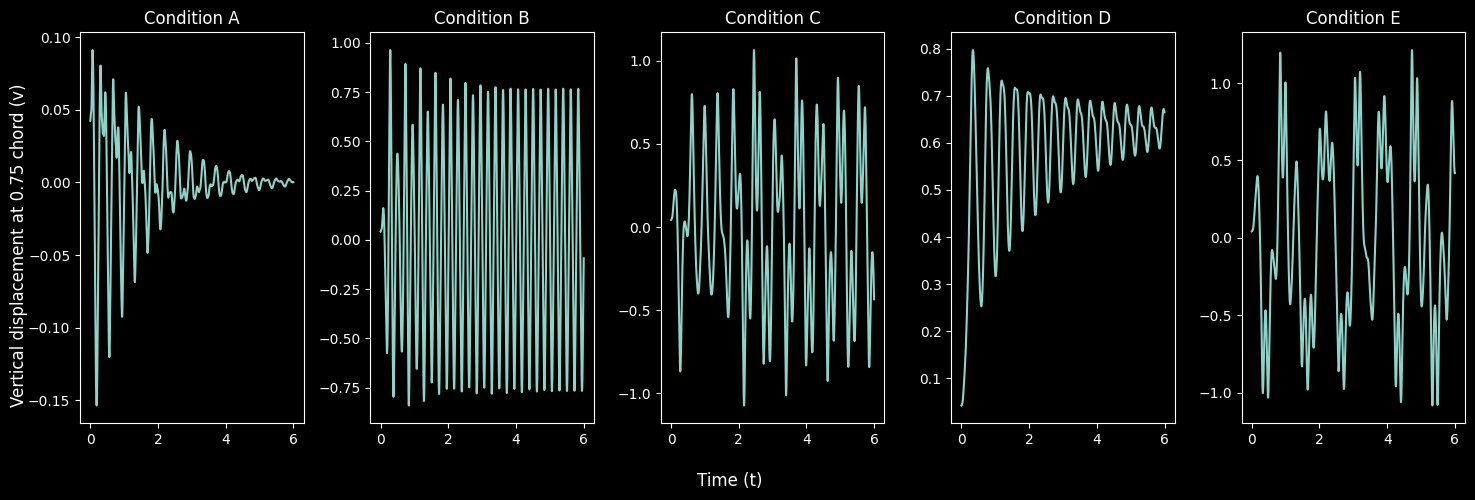

In [4]:
flutters = []
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

t_end = 6
dt = 0.002
i_condition = 2

for i in range(n_flutters):
    flutter_params = flutter_parameters[i]
    flutters.append(Flutter(flutter_params))
    flutters[i].matrix_coefficients()
    flutters[i].data_raw_plot(t_end,dt,i_condition,axes[i],"Condition "+chr(65+i)) # Initial Condition 2
    
fig.supylabel("Vertical displacement at 0.75 chord (v)")
fig.supxlabel("Time (t)")
plt.tight_layout()

print("Number of steps %d" % flutters[0].steps)

# PySINDy Forced Linearisation

<h3> Model Formulation </h3>

In [5]:
models = []
for i_flutter in range(n_flutters):
    ssr_optimizer = ps.SSR(alpha=0.05,criteria="model_residual",kappa=1e3) # Optimizer SSR Greedy Optimiser
    library_linear = ps.PolynomialLibrary(degree=1,include_bias=False) # Feature Library
    library = library_linear
    
    model = ps.SINDy(optimizer=ssr_optimizer,feature_library=library)
    model.fit(flutters[i_flutter].r,t=flutters[i_flutter].dt)
    models.append(model)

In [6]:
print(models[3].get_feature_names())
models[0].print()
models[3].print()

['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7']
(x0)' = 1.000 x4
(x1)' = 0.999 x5
(x2)' = 0.996 x6 + 0.001 x7
(x3)' = 0.015 x3 + 0.984 x7
(x4)' = 507.480 x1 + 184.029 x3
(x5)' = -714.416 x1 + 456.955 x3
(x6)' = -4653.092 x2 + 1576.122 x3
(x7)' = -23020.171 x3 + -1.315 x7
(x0)' = 1.000 x4
(x1)' = 0.999 x5
(x2)' = 0.996 x6
(x3)' = 0.007 x3 + 0.985 x7
(x4)' = -119.522 x0 + -901.000 x1
(x5)' = -78.019 x0 + -634.619 x1
(x6)' = -283.768 x2 + 472.477 x3
(x7)' = -32.878 x0 + -22137.821 x3


<h3> Model Evaluation </h3>

In [7]:
def test_set(model,flutter,i_condition_test,dt_test,t_end_test,i_flutter):
    r0_test = initial_conditions[i_condition_test]
    t_test =  np.arange(0,t_end_test,dt_test)
    r_test = odeint(flutter.ode, r0_test.T, t_test)
    steps_test = t_test.shape[0]
    
    print("Model %d : Condition %s" % (i_flutter, str(chr(65+i_flutter))))
    print("Number of steps %f" % steps_test)
    print("Model score: %f" % model.score(r_test, t=dt_test))
    
    return r0_test, t_test, r_test, steps_test
    
i_condition_test = 0
dt_test = 0.003
t_end_test = 5

r0_tests, t_tests, r_tests, steps_tests = [], [], [], []
for i_flutter in range(n_flutters):
    [r0_test, t_test, r_test, steps_test] = test_set(models[i_flutter],flutters[i_flutter],i_condition_test,dt_test,t_end_test,i_flutter)
    r0_tests.append(r0_test)
    t_tests.append(t_test)    
    r_tests.append(r_test)    
    steps_tests.append(steps_test)    

Model 0 : Condition A
Number of steps 1667.000000
Model score: 0.864987
Model 1 : Condition B
Number of steps 1667.000000
Model score: 0.952737
Model 2 : Condition C
Number of steps 1667.000000
Model score: 0.962281
Model 3 : Condition D
Number of steps 1667.000000
Model score: 0.580695
Model 4 : Condition E
Number of steps 1667.000000
Model score: 0.873052


<h3> Model Prediction </h3>

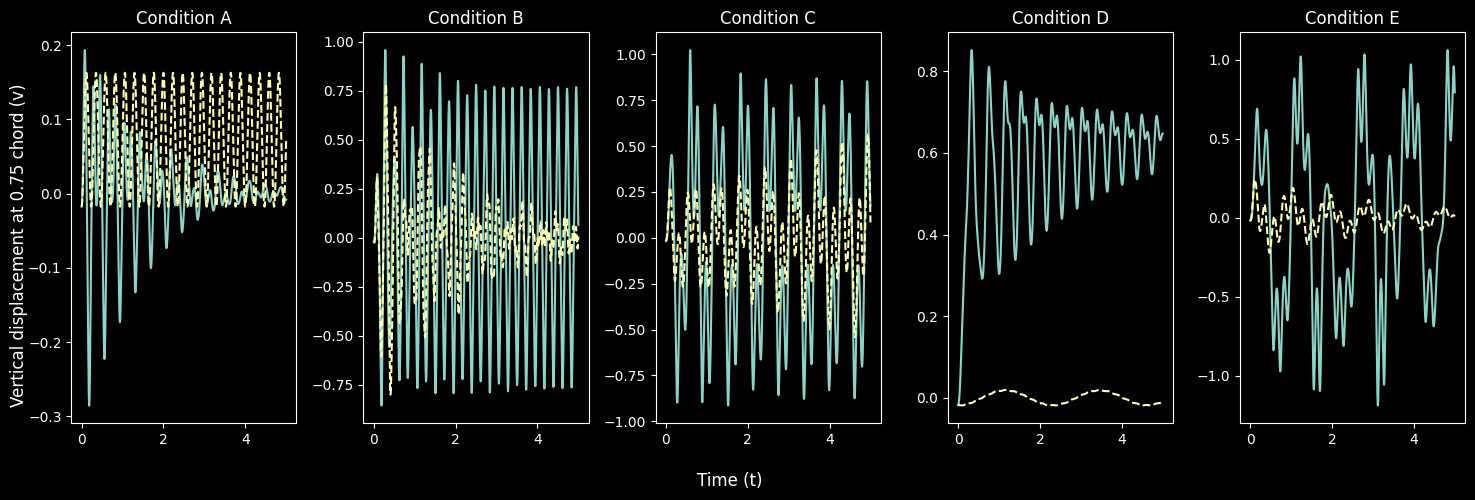

In [8]:
def plot_pred(model,flutter,r0_test,r_test,t_test,steps_test,axes,title=""):
    r_test_pred = model.simulate(r0_test, t_test)
    v_test_pred = np.dot(flutter.C.T,r_test_pred[:,:4].T).reshape(steps_test,1)
    v_test = np.dot(flutter.C.T,r_test[:,:4].T).reshape(steps_test,1)

    if axes != None:
        axes.plot(t_test,v_test)
        axes.plot(t_test,v_test_pred,'--')
        axes.set_title(title)
    else:
        plt.plot(t_test,v_test)
        plt.plot(t_test,v_test_pred,'--')
        plt.legend(["True","Prediction"])
        plt.xlabel("Time")
        plt.ylabel("Vertical displacement")
        plt.title("True vs Predicted vertical displacement at quarter chord")
        plt.show()

fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i_flutter in range(n_flutters):
    plot_pred(models[i_flutter],flutters[i_flutter],r0_tests[i_flutter],r_tests[i_flutter],t_tests[i_flutter],steps_tests[i_flutter],axes[i_flutter],"Condition "+chr(65+i_flutter))
    
fig.supylabel("Vertical displacement at 0.75 chord (v)")
fig.supxlabel("Time (t)")
plt.tight_layout()

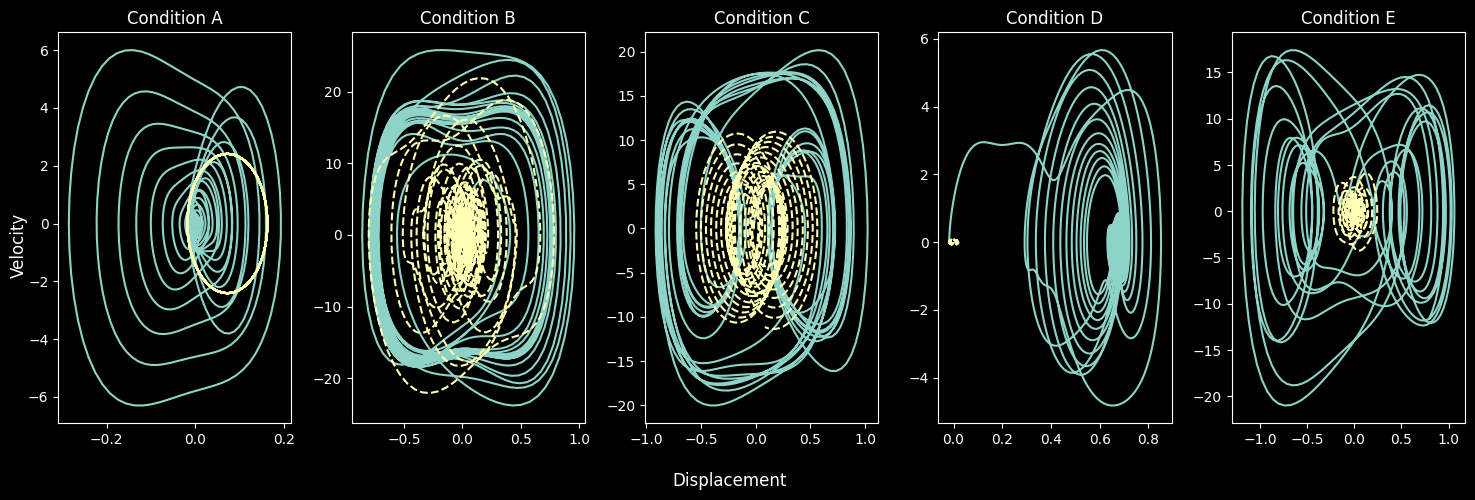

In [9]:
def plot_state_pred(model,flutter,r0_test,r_test,t_test,steps_test,axes,title=""):
    r_test_pred = model.simulate(r0_test, t_test)
    v_test_pred = np.dot(flutter.C.T,r_test_pred[:,:4].T).reshape(steps_test,1)
    v_test = np.dot(flutter.C.T,r_test[:,:4].T).reshape(steps_test,1)
    v_dot_test_pred = np.dot(flutter.C.T,r_test_pred[:,4:8].T).reshape(steps_test,1)
    v_dot_test = np.dot(flutter.C.T,r_test[:,4:8].T).reshape(steps_test,1)
    
    if axes != None:
        axes.plot(v_test,v_dot_test)
        axes.plot(v_test_pred,v_dot_test_pred,'--')
        axes.set_title(title)
    else:
        plt.plot(v_test,v_dot_test)
        plt.plot(v_test_pred,v_dot_test_pred,'--')
        plt.legend(["True","Prediction"])
        plt.xlabel("Displacement")
        plt.ylabel("Velocity")
        plt.title("True vs Predicted State space trajectory at quarter chord")
        plt.show()
        
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i_flutter in range(n_flutters):
    plot_state_pred(models[i_flutter],flutters[i_flutter],r0_tests[i_flutter],r_tests[i_flutter],t_tests[i_flutter],steps_tests[i_flutter],axes[i_flutter],"Condition "+chr(65+i_flutter))
    
fig.supylabel("Velocity")
fig.supxlabel("Displacement")
plt.tight_layout()

# PySINDy Full Model

<h3> Model Formulation (Different initial condition for robustness test) </h3>

In [15]:
models_full = []
for i_flutter in range(3):
    ssr_optimizer = ps.SSR(alpha=0.05,criteria="model_residual",kappa=1e3) # Optimizer SSR Greedy Optimiser
    library_linear = ps.PolynomialLibrary(degree=1,include_bias=False) # Feature Library
    non_linear_functions = [lambda x:x**3, lambda x,y: x*y**2]
    non_linear_function_names = [lambda x:x+"^3", lambda x,y: x+"*"+y+"^2"]
    library_non_linear = ps.CustomLibrary(library_functions=non_linear_functions,function_names=non_linear_function_names) 
    library = library_linear+library_non_linear
    
    model = ps.SINDy(optimizer=ssr_optimizer,feature_library=library)
    model.fit(flutters[i_flutter].r,t=flutters[i_flutter].dt)
    models_full.append(model)

In [16]:
print(models_full[0].get_feature_names())

['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x0^3', 'x1^3', 'x2^3', 'x3^3', 'x4^3', 'x5^3', 'x6^3', 'x7^3', 'x0*x1^2', 'x0*x2^2', 'x0*x3^2', 'x0*x4^2', 'x0*x5^2', 'x0*x6^2', 'x0*x7^2', 'x1*x2^2', 'x1*x3^2', 'x1*x4^2', 'x1*x5^2', 'x1*x6^2', 'x1*x7^2', 'x2*x3^2', 'x2*x4^2', 'x2*x5^2', 'x2*x6^2', 'x2*x7^2', 'x3*x4^2', 'x3*x5^2', 'x3*x6^2', 'x3*x7^2', 'x4*x5^2', 'x4*x6^2', 'x4*x7^2', 'x5*x6^2', 'x5*x7^2', 'x6*x7^2']


<h3> Model Evaluation </h3>

In [17]:
i_condition_test = 0
dt_test = 0.003
t_end_test = 5

r0_tests, t_tests, r_tests, steps_tests = [], [], [], []
for i_flutter in range(3):
    [r0_test, t_test, r_test, steps_test] = test_set(models_full[i_flutter],flutters[i_flutter],i_condition_test,dt_test,t_end_test,i_flutter)
    r0_tests.append(r0_test)
    t_tests.append(t_test)    
    r_tests.append(r_test)    
    steps_tests.append(steps_test)    

Model 0 : Condition A
Number of steps 1667.000000
Model score: 0.370980
Model 1 : Condition B
Number of steps 1667.000000
Model score: 0.991979
Model 2 : Condition C
Number of steps 1667.000000
Model score: 0.996918


<h3> Model Prediction </h3>

0
1
2


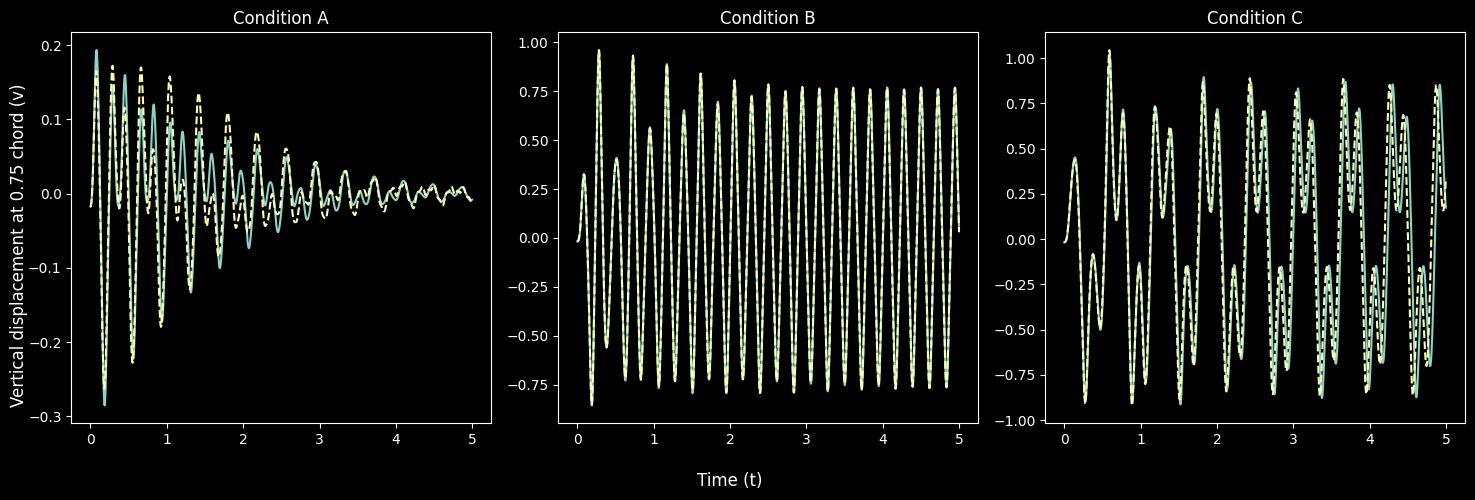

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i_flutter in range(3):
    print(i_flutter)
    if i_flutter != 3:
        plot_pred(models_full[i_flutter],flutters[i_flutter],r0_tests[i_flutter],r_tests[i_flutter],t_tests[i_flutter],steps_tests[i_flutter],axes[i_flutter],"Condition "+chr(65+i_flutter))
    
fig.supylabel("Vertical displacement at 0.75 chord (v)")
fig.supxlabel("Time (t)")
plt.tight_layout()

0
1
2


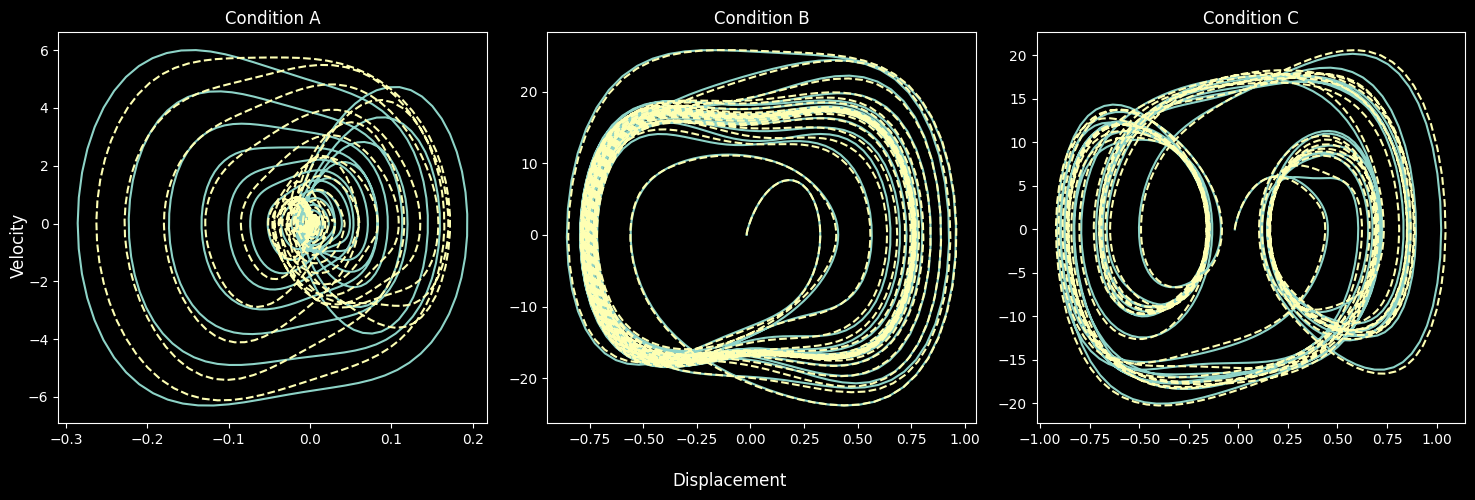

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i_flutter in range(3):
    print(i_flutter)
    plot_state_pred(models_full[i_flutter],flutters[i_flutter],r0_tests[i_flutter],r_tests[i_flutter],t_tests[i_flutter],steps_tests[i_flutter],axes[i_flutter],"Condition "+chr(65+i_flutter))
    
fig.supylabel("Velocity")
fig.supxlabel("Displacement")
plt.tight_layout()